In [58]:
from dotenv import load_dotenv

load_dotenv()

True

In [59]:
from langchain_openai import ChatOpenAI

llm = ChatOpenAI(model='gpt-4o-mini')

In [60]:
from langsmith import Client

client = Client()

In [61]:
from langchain_chroma import Chroma
from langchain_openai import OpenAIEmbeddings

vector_store = Chroma(
    embedding_function=OpenAIEmbeddings(model='text-embedding-3-large'),
    collection_name='income_tax_collections',
    persist_directory='./income_tax_collections'
)
retriever = vector_store.as_retriever(search_kwargs={'k': 3})

In [62]:
from typing import Literal
from typing_extensions import TypedDict
from langchain_core.prompts import PromptTemplate
from langchain_core.output_parsers import StrOutputParser

class AgentState(TypedDict):
    query: str
    context: list
    answer: str

In [63]:
def retrieve(state: AgentState) -> AgentState:
    """
    'retrieve' Node
    : 사용자의 질문에 기반하여, 벡터 스토어에서 관련 문서를 검색한다.

    Args:
        - state(AgentState): 사용자의 질문을 포함한 에이전트의 현재 state

    Returns:
        - AgentState: 검색된 문서가 추가된 state
    """
    
    query = state['query']
    context = retriever.invoke(query)
    
    return {'context': context}

In [64]:
rag_prompt = client.pull_prompt("rlm/rag-prompt", include_model=True)

def generate(state: AgentState) -> AgentState:
    """
    'generate' Node
    : 사용자의 질문과 검색된 문서를 기반으로 응답을 생성한다.

    Args:
        - state(AgentState): 사용자의 질문과 검색된 문서를 포함한 에이전트의 현재 state

    Returns:
        - AgentState: 생성된 응답이 추가된 state
    """
    
    query = state['query']
    context = state['context']
    
    rag_chain = rag_prompt | llm
    ai_message = rag_chain.invoke({'question': query, 'context': context})
    
    return {'answer': ai_message}

In [ ]:
rewrite_prompt = PromptTemplate.from_template(
    """
    사용자의 질문을 보고, 웹 검색에 용이하도록 질문을 변경해주세요.
    
    질문: {query}
    """
)

def rewrite(state: AgentState) -> AgentState:
    """
    'rewrite' Node
    : 사용자의 질문을 웹 검색용으로 변경한다.

    Args:
        - state(AgentState): 사용자의 질문을 포함한 에이전트의 현재 state

    Returns:
        - AgentState: 변경된 질문을 포함하는 state
    """
    
    query = state['query']
    
    rewrite_chain = rewrite_prompt | llm | StrOutputParser()
    ai_message = rewrite_chain.invoke({'query': query})
    
    return {'query': ai_message}

In [66]:
doc_relevance_prompt = client.pull_prompt("langchain-ai/rag-document-relevance", include_model=True)

def check_doc_relevance(state: AgentState) -> Literal['relevant', 'irrelevant']:
    """
    : 주어진 state를 기반으로 문서의 관련성을 판단한다.

    Args:
        - state(AgentState): 사용자의 질문과 문맥을 포함한 에이전트의 현재 state

    Returns:
        - Literal['relevant', 'irrelevant']: 문서가 관련성이 높으면 'relevant', 그렇지 않으면 'irrelevant' 반환
    """
    
    query = state['query']
    context = state['context']
    
    doc_relevance_chain = doc_relevance_prompt | llm
    ai_message = doc_relevance_chain.invoke({'question': query, 'documents': context})
    
    ## node를 직접 지정하는 방식 대신 실제 판단 결과를 리턴함으로써 해당 node의 재사용성을 높일 수 있다.
    return 'relevant' if ai_message['Score'] == 1 else 'irrelevant'

In [67]:
from langchain_community.tools import TavilySearchResults

tavily_search_tool = TavilySearchResults(
    max_results=3,
    search_depth="advanced",
    include_answer=True,
    include_raw_content=True,
    include_images=True,
)

In [ ]:
def web_search(state: AgentState) -> AgentState:
    """
    'web_search' Node
    : 주어진 state를 기반으로 웹 검색을 수행한다.

    Args:
        - state(AgentState): 사용자의 질문을 포함한 에이전트의 현재 state

    Returns:
        - AgentState: 웹 검색 결과가 추가된 state
    """
    
    query = state['query']
    
    # 웹 검색 도구 활용
    results = tavily_search_tool.invoke(query)
    
    return {'context': results}

In [69]:
from langgraph.graph import StateGraph, START, END

graph_builder = StateGraph(AgentState)

# nodes
graph_builder.add_node('retrieve', retrieve)
graph_builder.add_node('generate', generate)
## graph_builder.add_node('rewrite', rewrite)
graph_builder.add_node('web_search', web_search)

# edges
graph_builder.add_edge(START, 'retrieve')
graph_builder.add_conditional_edges(
    'retrieve',
    check_doc_relevance,
    {
        'relevant': 'generate',
        'irrelevant': 'web_search'
    }
)
## graph_builder.add_edge('rewrite', 'web_search')
graph_builder.add_edge('web_search', 'generate')
graph_builder.add_edge('generate', END)

In [70]:
graph = graph_builder.compile()

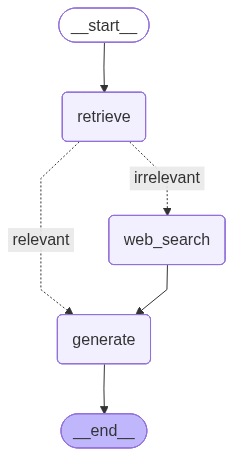

In [71]:
from IPython.display import Image, display

display(Image(graph.get_graph().draw_mermaid_png()))

In [72]:
query1 = "연봉 5천만원인 거주자가 납부해야 하는 소득세는 얼마인가요?"
query2 = "군자역 맛집을 알려주세요."
initial_state = {'query': query2}

graph.invoke(initial_state)

{'query': '군자역 맛집을 알려주세요.',
 'context': [{'title': '군자 맛집 베스트 추천 top 10',
   'url': 'https://hotel-iu.tistory.com/4151',
   'content': "|  |\n\n| 9: 서울돼지구이 |\n|  |\n| 상호명: 서울돼지구이  주소: 서울특별시 광진구 능동 283-27 한사랑빌딩 1층  전화번호: 070-7537-1057  관련 키워드: ['삼겹살', '황지살', '돼지갈비', '밀면', '돼지껍데기']  관련 태그: ['모임하기 좋은', '데이트하기 좋은', '특별한 날']  영업시간: 매일 16:30~23:30 휴무없음 |\n| 소개글: 안녕하세요! 군자역 맛집 서울돼지구이 입니다.  숙성으로 맛을 더한 숙성 삼겹살과 시원한 부산밀면을 같이 드실수있으며, 무화과로 연육해 더욱 건강하고 맛있는 돼지갈비와 각종 매스컴에서 이슈가 된 황지살도 준비되어 있습니다.  주차가 가능한 고깃집이며, 콜키지도 프리로 이용가능합니다.  세종대 근처이며 어린이대공원과도 가까워 단체 회식이나 가족 외식에도 안성맞춤 입니다.  최고의 맛과 정성의 서비스 그리고 다양헌 곁들임으로 행복하고 맛있는 시간되세요! |\n|  서울돼지구이 바로가기▲ |\n\n|  | [...] | 소개글: 안녕하세요. 서울 광진구 군자역 고기집 에이뿔램입니다.  에이뿔램 군자점은 13년 동안 양고기만을 연구한 모든 노하우를 녹여서 오픈한 양고기 전문점입니다.  양고기 전문점을 운영하는동안 꾸준한 사랑을 받고 있으며, 약 300명이 넘은 연예인, 단골 분들과 추억을 함께 했습니다.  지금은 군자역 근처로 확장 이전하여 더 많은 분들과 추억을 함께 하기 위해 노력하고 있습니다.  지금까지 에이뿔램이 꾸준한 사랑받을 수 있었던 이유를 알려드리겠습니다.  딱 30초만 아래 글을 읽어보시길 바랍니다.  [믿고 먹을 수 있는 양고기 전문점]  - 양고기 최대 수출국인 호주의 탑 브랜드 고기만 취급 - 양고기 유통 15년 경